## 1. Import Libraries
In this step, we import the necessary Python libraries for data manipulation, visualization, image processing, and machine learning tasks. Warnings are suppressed for readability.

In [6]:
!pip install opencv-python
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import shutil
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 9.0 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## 2. Load Metadata
We load the metadata CSV file that accompanies the HAM10000 dermoscopic image dataset. This metadata includes important information like the diagnosis label (`dx`), patient age, sex, and lesion localization. We begin by previewing the data to understand its structure.

In [7]:
# Load metadata CSV file from the HAM10000 dataset
metadata = pd.read_csv('/Users/manuelramirez/Documents/teledermatology project/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## 3. Check for Duplicates and Missing Values
We perform data quality checks to identify duplicate records and missing values. This helps us assess whether the dataset is clean or if it needs preprocessing to ensure consistency and completeness before modeling.

In [8]:
# Check for duplicates
metadata.duplicated().sum()

# Check for missing values
metadata.isnull().sum()


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

## 4. Unique Values per Column
Here, we inspect how many unique values each column contains. This helps us identify categorical columns and potential data encoding issues or inconsistencies.

In [9]:
for col in metadata.columns:
    print(f"{col}: {metadata[col].nunique()} unique values")

lesion_id: 7470 unique values
image_id: 10015 unique values
dx: 7 unique values
dx_type: 4 unique values
age: 18 unique values
sex: 3 unique values
localization: 15 unique values


## 5. Handle Missing Values
To deal with missing values:
- We replace missing values in the `age` column with the median, which is less sensitive to outliers than the mean.
- For `sex` and `localization`, we replace missing values with 'unknown' to preserve the rows and avoid data loss.

In [10]:
# Fill missing values in 'age' with the median
metadata['age'] = metadata['age'].fillna(metadata['age'].median())

# Fill missing values in 'sex' with 'unknown'
metadata['sex'] = metadata['sex'].fillna('unknown')

# Fill missing values in 'localization' with 'unknown'
metadata['localization'] = metadata['localization'].fillna('unknown')

## 6. Visualize Class Distribution
We visualize the distribution of diagnostic categories using a bar chart. This helps us assess class imbalance, which will later guide decisions about model training strategies such as resampling or augmentation.

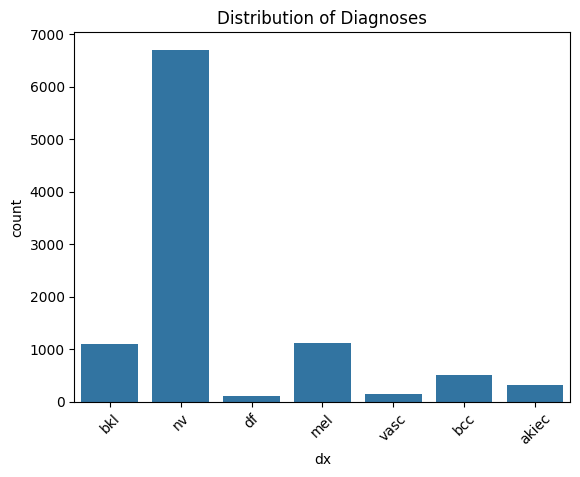

In [11]:
sns.countplot(x='dx', data=metadata)
plt.title('Distribution of Diagnoses')
plt.xticks(rotation=45)
plt.show()

## 7. Summary Statistics and Outlier Detection
We generate summary statistics for numeric columns (especially `age`) and plot a boxplot to visually check for outliers. Although we do not remove outliers at this stage, this insight helps us understand the spread and central tendency of key features.

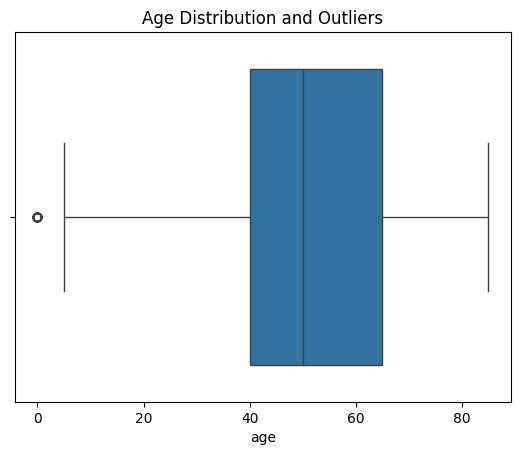

In [12]:
# Summary statistics
metadata.describe()

# Boxplot to visually inspect age outliers
sns.boxplot(data=metadata, x='age')
plt.title('Age Distribution and Outliers')
plt.show()


## 8. Verify Existence of Image Files
Since our classification task relies on image data, we verify that all images listed in the metadata are present in the specified image directory. This ensures the integrity of the dataset and prevents errors during model training.

In [13]:
# Check that all image files exist across both folders
img_dirs = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
missing = []

for image_id in metadata['image_id']:
    found = False
    for folder in img_dirs:
        image_path = os.path.join(folder, image_id + ".jpg")
        if os.path.isfile(image_path):
            found = True
            break
    if not found:
        missing.append(image_id)

print(f"Missing images: {len(missing)}")


Missing images: 0


## 9. Encode Diagnosis Labels
We map each unique diagnosis (`dx`) value to a numeric label using a dictionary. This encoding allows the model to interpret the target variable during supervised learning.

In [14]:
# Create a label encoder dictionary
label_dict = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
metadata['label'] = metadata['dx'].map(label_dict)

# Save cleansed dataset
metadata.to_csv('cleansed_HAM10000_metadata.csv', index=False)